In [1]:
%%capture
!pip install --upgrade tensorflow 

Make sure that the version of tensorflow is greater than 2.9.0.


In [2]:
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
print(tf.__version__)

2023-07-06 10:21:59.324049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 10:22:00.034498: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 10:22:00.396539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-06 10:22:00.396587: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

2.11.0


## Importing Required Libraries


In [3]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

## MNIST data


MNIST dataset contains 70,000 handwritten black-and-white images, which are traditionally split into 60k training images and 10k validation images.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data();

### Preprocess MNIST


We'll preprocess by scaling images pixels to be between 0 and 1.


In [5]:
x_train = x_train.astype('float') / 255.
x_test = x_test.astype('float') / 255.

### PCA


Using PCA as a baseline.


In [6]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


PCA works better if our features are scaled. 


In [ ]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [8]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(

In [9]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


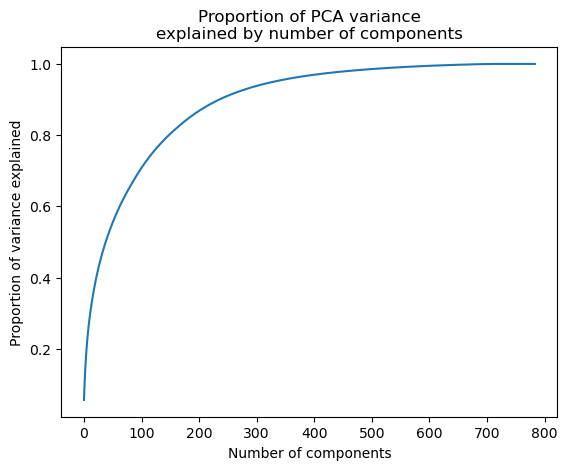

In [10]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

For visualization purposes, let's extract just two components and plot them:


In [11]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.1


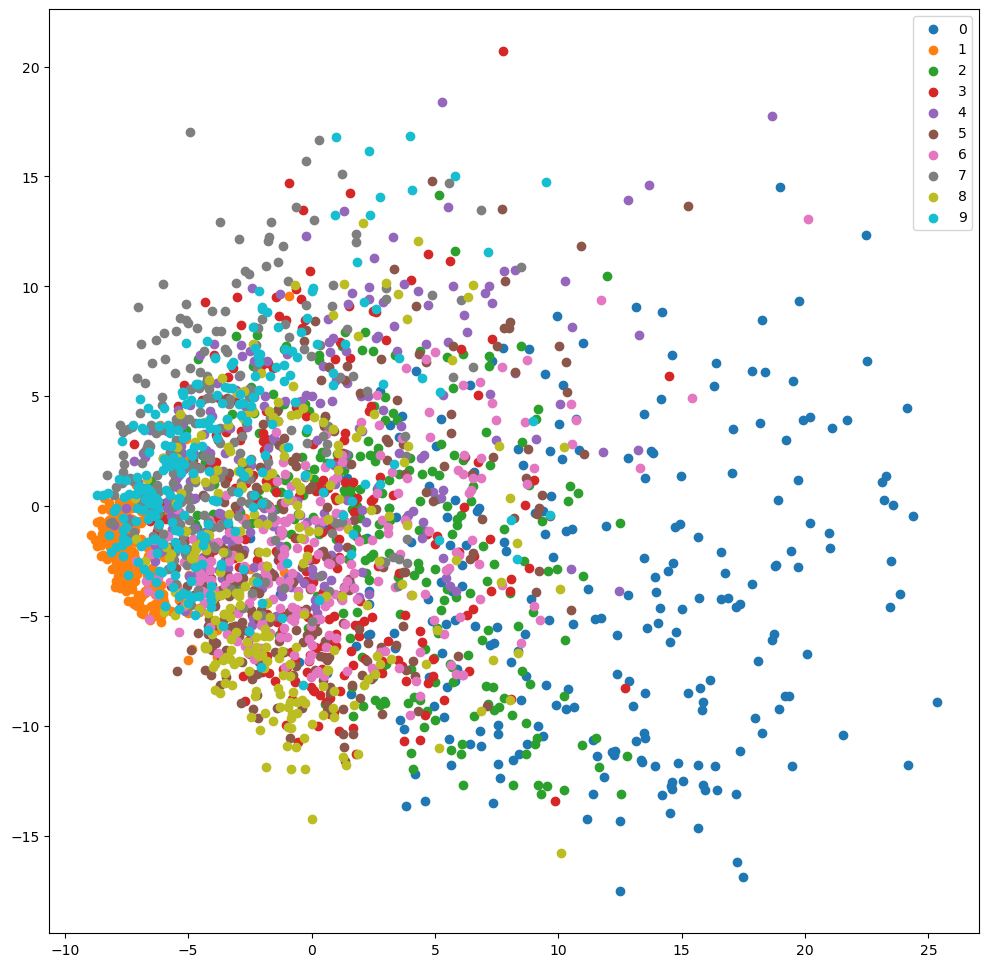

In [12]:
num_images_per_class = 250
fig = plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend();

### Scoring PCA


In [ ]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

In [ ]:
s = StandardScaler().fit(x_test_flat)
x_test_scaled = s.transform(x_test_flat)

In [ ]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [ ]:
x_test_reconstructed_64.shape

In [ ]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [ ]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [ ]:
mse_reconstruction(true, reconstructed)

### Simple AE


In [20]:
from keras.layers import Input, Dense
from keras.models import Model

Defining three models:

* The "full autoencoder", will take inputs and try to reconstruct them
* The "encoder", will take inputs and try to reconstruct them
* The "decoder", will take the latent space and try to reconstruct it


In [21]:
ENCODING_DIM = 64

# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

2023-07-06 09:49:06.096409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-06 09:49:06.096496: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-06 09:49:06.096564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab-antonismyrsi): /proc/driver/nvidia/version does not exist
2023-07-06 09:49:06.097115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [23]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 [==============================] - 11s 6ms/step - loss: 0.2716 - accuracy: 0.0126


In [24]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 [==============================] - 1s 1ms/step


(10000, 64)

Encoding of the first image.


In [25]:
encoded_images[0]

array([0.96, 0.96, 0.98, 0.98, 0.98, 0.98, 0.97, 0.98, 0.98, 0.97, 0.31,
       0.92, 0.74, 0.76, 0.97, 0.97, 0.98, 0.97, 0.97, 0.98, 0.97, 0.24,
       0.97, 0.98, 0.98, 0.47, 0.96, 0.97, 0.93, 0.97, 0.95, 0.96, 0.9 ,
       0.98, 0.96, 0.98, 0.83, 0.97, 0.96, 0.97, 0.94, 0.98, 0.97, 0.94,
       0.91, 0.97, 0.96, 0.98, 0.78, 0.97, 0.98, 0.98, 0.98, 0.91, 0.95,
       0.98, 0.97, 0.98, 0.97, 0.96, 0.96, 0.93, 0.98, 0.98],
      dtype=float32)

### Scoring of Simple Autoencoder


In [26]:
### BEGIN SOLUTION
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

313/313 [==============================] - 1s 2ms/step


647.301252782863

### Adding more layers


In [27]:
ENCODING_DIM = 64
HIDDEN_DIM = 256
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [28]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [29]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1583 - accuracy: 0.0102
Epoch 2/2
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1026 - accuracy: 0.0114


In [30]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

313/313 [==============================] - 1s 2ms/step


98.92088692811174

### Adding more epochs


In [31]:
def train_ae_epochs(num_epochs=1):
### BEGIN SOLUTION
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    # Encoder model
    inputs = Input(shape=(784,)) 
    encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
    encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
    encoder_model = Model(inputs, encoded, name='encoder')

    # Decoder model
    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')
    
    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
    
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))
### END SOLUTION       
    return mse_res


In [32]:
train_ae_epochs(5)

313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 1 is 148.86474586876653
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 2 is 107.84436362088096
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 3 is 85.94212040485024
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 4 is 73.84888962338988
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 5 is 62.01866008021073


[148.86474586876653,
 107.84436362088096,
 85.94212040485024,
 73.84888962338988,
 62.01866008021073]

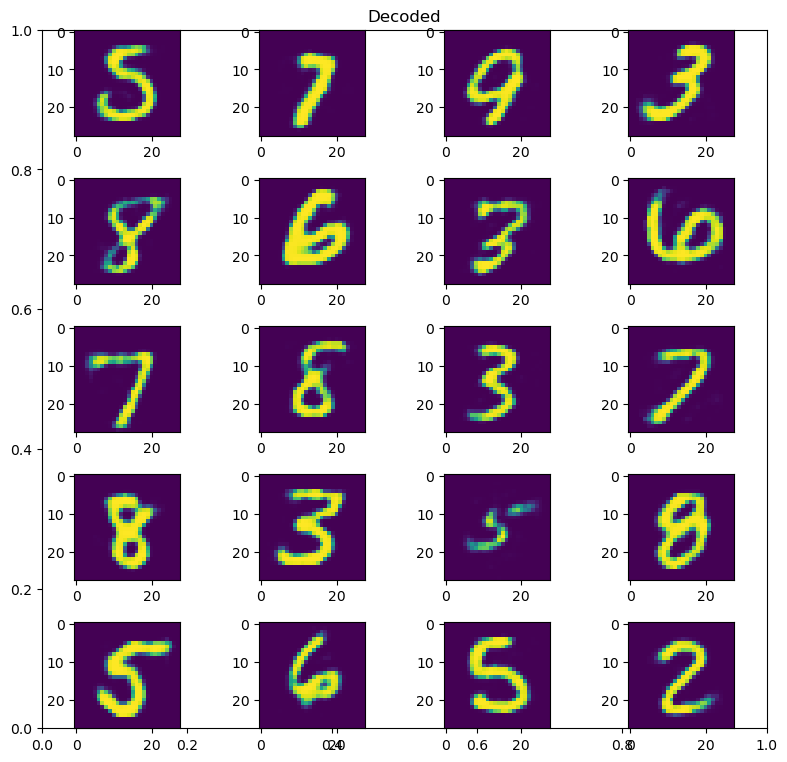

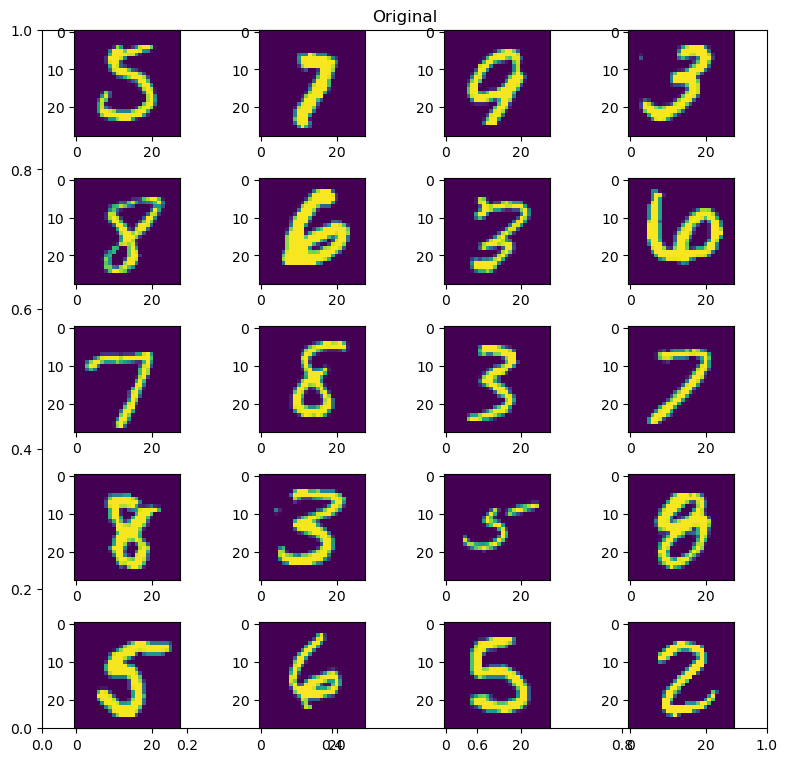

In [ ]:
predicted_images = decoded_images.reshape((-1,28,28))
test_ids = np.random.choice(len(predicted_images), size=(columns*rows), replace=False)
columns = 4
rows = 5
imgsPlot = predicted_images[test_ids]

fig = plt.figure(figsize=(8, 8))
plt.title('Decoded')
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(imgsPlot[i])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.title('Original')
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[test_ids[i]])
plt.tight_layout()
plt.show()